In [2]:
!pip install catboost


   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 3.0 MB/s eta 0:00:34
   ---------------------------------------- 1.0/101.7 MB 2.5 MB/s eta 0:00:41
    --------------------------------------- 1.6/101.7 MB 2.6 MB/s eta 0:00:39
    --------------------------------------- 2.4/101.7 MB 2.6 MB/s eta 0:00:38
   - -------------------------------------- 2.9/101.7 MB 2.6 MB/s eta 0:00:39
   - -------------------------------------- 3.1/101.7 MB 2.6 MB/s eta 0:00:39
   - -------------------------------------- 3.7/101.7 MB 2.4 MB/s eta 0:00:41
   - -------------------------------------- 3.9/101.7 MB 2.3 MB/s eta 0:00:43
   - -------------------------------------- 4.2/101.7 MB 2.2 MB/s eta 0:00:44
   - -------------------------------------- 4.5/101.7 MB 2.1 MB/s eta 0:00:46
   - -------------------------------------- 4.5/101.7 MB 2.1 MB/s eta 0:00:46
   - -------------------------------------- 4.7/101.7 MB 1.9 MB/s eta 0

In [27]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error as msle

In [28]:
# read the dataset
data = pd.read_csv('final_data.csv')

In [29]:
# check for the null values
data.isna().sum().sum()

0

In [30]:
data.loc[0]

WEEK_END_DATE               2009-01-14
STORE_NUM                          367
UPC                         1111009477
BASE_PRICE                        1.57
FEATURE                              0
DISPLAY                              0
UNITS                               13
MANUFACTURER_1                       1
MANUFACTURER_2                       0
MANUFACTURER_3                       0
MANUFACTURER_4                       0
MANUFACTURER_5                       0
MANUFACTURER_6                       0
MANUFACTURER_7                       0
MANUFACTURER_8                       0
MANUFACTURER_9                       0
CATEGORY_1                           1
CATEGORY_2                           0
CATEGORY_3                           0
CATEGORY_4                           0
SUB_CATEGORY_1                       1
SUB_CATEGORY_2                       0
SUB_CATEGORY_3                       0
SUB_CATEGORY_4                       0
SUB_CATEGORY_5                       0
SUB_CATEGORY_6           

In [31]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [32]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [33]:
week = data.WEEK_END_DATE.unique()

In [34]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [35]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,train_start_1,train_end_1,train_start_2,validate_week,test_week,no_days_train_1,no_days_train_2,set_no
0,2011-07-13,2011-08-31,2011-07-27,2011-09-14,2011-09-28,56 days,56 days,set1
1,2011-07-06,2011-08-24,2011-07-20,2011-09-07,2011-09-21,56 days,56 days,set2
2,2011-06-29,2011-08-17,2011-07-13,2011-08-31,2011-09-14,56 days,56 days,set3
3,2011-06-22,2011-08-10,2011-07-06,2011-08-24,2011-09-07,56 days,56 days,set4
4,2011-06-15,2011-08-03,2011-06-29,2011-08-17,2011-08-31,56 days,56 days,set5
5,2011-06-08,2011-07-27,2011-06-22,2011-08-10,2011-08-24,56 days,56 days,set6
6,2011-06-01,2011-07-20,2011-06-15,2011-08-03,2011-08-17,56 days,56 days,set7
7,2011-05-25,2011-07-13,2011-06-08,2011-07-27,2011-08-10,56 days,56 days,set8
8,2011-05-18,2011-07-06,2011-06-01,2011-07-20,2011-08-03,56 days,56 days,set9
9,2011-05-11,2011-06-29,2011-05-25,2011-07-13,2011-07-27,56 days,56 days,set10


In [36]:
# define a function to calculate the evaluation sets.
# this time we will include test set also
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [37]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [38]:
# function to calculate the root mean squared log error
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))

In [39]:
def get_results_on_evaluation_set(eval_set, model):
    results = []
    set_n = 1
    for eval_data in tqdm(eval_set):
        
        x = {}
        train_data_1, validate, train_data_2, test = eval_data
        
        # separate the independent and target variables from train and valid
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']
        
        train_data_2_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_2_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        # fit the model on the training data
        model_valid = model.fit(train_data_1_x, train_data_1_y)
        
        # predict the target on train and validate
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
                
        
        # fit the model on the training data
        model_test  = model.fit(train_data_2_x, train_data_2_y)
        
        # predict the target on train and test
        predict_train_2 = model_test.predict(train_data_2_x).clip(min=0)
        predict_test    = model_test.predict(test_x).clip(min=0)
        
        
        # calculate the rmsle on train and valid
        rmsle_train_1 = get_msle(train_data_1_y, predict_train_1)
        rmsle_valid   = get_msle(validate_y, predict_valid)
        
        # calculate the rmsle on train and test
        rmsle_train_2 = get_msle(train_data_2_y, predict_train_2)
        rmsle_test    = get_msle(test_y, predict_test)
        
        
        x['set_no'] = set_n
        set_n +=1
        x['rmsle_train_1'] = rmsle_train_1
        x['rmsle_valid'] = rmsle_valid
        x['rmsle_train_2'] = rmsle_train_2
        x['rmsle_test'] = rmsle_test
        results.append(x)
        
        
    return pd.DataFrame.from_dict(results)
        

# define function to get the best 10 feature importance plot
def get_feature_importance(eval_set, model):
    train_data_1, validate, train_data_2, test = eval_set
    
    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']
        
    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    model.fit(train_data_x, train_data_y)
    (pd.Series(model.feature_importances_, index=train_data_x.columns).nlargest(10).plot(kind='barh')) 


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get and plot the top 10 feature importances
def get_feature_importance(eval_set, model):
    # Unpack dataset
    train_data_1, validate, train_data_2, test = eval_set
    
    # Extract features and target
    train_data_x = train_data_2.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'], errors='ignore')
    train_data_y = train_data_2['UNITS']
    
    test_x = test.drop(columns=['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'], errors='ignore')
    test_y = test['UNITS']
    
    # Fit the model (ensure it's trained)
    model.fit(train_data_x, train_data_y)
    
    # Extract feature importance
    feature_importance = pd.Series(model.feature_importances_, index=train_data_x.columns)
    top_10_features = feature_importance.nlargest(10)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_10_features.plot(kind='barh', color='purple')
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()
    
    return top_10_features  # Return feature importance values



In [51]:
### define randomforest model
model_rf = RandomForestRegressor(max_depth=10, n_estimators=175, random_state=0)

# calculate the results using the random forest
results_RFR = get_results_on_evaluation_set(evaluation_sets, model_rf)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [05:16<00:00, 22.60s/it]


In [52]:
results_RFR[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.354970,0.415476
1,0.357439,0.499669
2,0.365272,0.406321
3,0.352390,0.466678
4,0.348456,0.556271
5,0.353550,0.480295
6,0.344304,0.490637
7,0.339212,0.545311
8,0.334285,0.439274
9,0.337396,0.478067


In [43]:
import lightgbm as lgb


model_LGBM = lgb.LGBMRegressor(
    n_estimators=720,  
    bagging_fraction=1,  
    max_depth=4,  
    min_child_samples=2,  
    lambda_l1=0,  
    learning_rate=0.01,  
    n_jobs=4, 
    random_state=0, 
    objective='regression', 
    metric='rmse'  
)


In [44]:
# calculate the results using xgboost
results_lightgbm = get_results_on_evaluation_set(evaluation_sets, model_LGBM)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 34
[LightGBM] [Info] Start training from score 27.764459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

  7%|█████▉                                                                             | 1/14 [00:03<00:48,  3.71s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 13102, number of used features: 34
[LightGBM] [

 14%|███████████▊                                                                       | 2/14 [00:06<00:39,  3.33s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 13101, number of used features: 35
[LightGBM] [

 21%|█████████████████▊                                                                 | 3/14 [00:09<00:35,  3.21s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 975
[LightGBM] [Info] Number of data points in the train set: 13101, number of used features: 35
[LightGBM] [

 29%|███████████████████████▋                                                           | 4/14 [00:13<00:33,  3.36s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 13109, number of used features: 35
[LightGBM] [Info] Start training from score 30.308948
[LightGBM] [Warning] N

 36%|█████████████████████████████▋                                                     | 5/14 [00:16<00:30,  3.38s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 13108, number of used features: 35
[LightGBM] [

 43%|███████████████████████████████████▌                                               | 6/14 [00:20<00:27,  3.45s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 13108, number of used features: 35
[LightGBM] [

 50%|█████████████████████████████████████████▌                                         | 7/14 [00:23<00:24,  3.46s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 13112, number of used features: 35
[LightGBM] [

 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:27<00:20,  3.48s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 13104, number of used features: 35
[LightGBM] [

 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:31<00:18,  3.66s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 13101, number of used features: 34
[LightGBM] 

 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:35<00:14,  3.70s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1051
[LightGBM] [Info] Number of data points in the train set: 13106, number of used features: 34
[LightGBM] 

 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:39<00:11,  3.96s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 13102, number of used features: 34
[LightGBM] [Info] Start training from score 27.490765
[LightGBM] [Warning] 

 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:43<00:07,  3.83s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 13096, number of used features: 34
[LightGBM] 

 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:46<00:03,  3.58s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 13093, number of used features: 34
[LightGBM] [Info] Start training from score 27.441610
[LightGBM] [Warning] 

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:50<00:00,  3.64s/it]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [45]:
results_lightgbm[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.408772,0.430250
1,0.410575,0.487522
2,0.414099,0.408016
3,0.406814,0.469286
4,0.402295,0.544482
5,0.405497,0.482250
6,0.396148,0.481794
7,0.392164,0.543877
8,0.387501,0.456078
9,0.386326,0.464366


In [53]:
results_lightgbm[['rmsle_train_2', 'rmsle_test']].mean()

rmsle_train_2    0.400841
rmsle_test       0.469362
dtype: float64

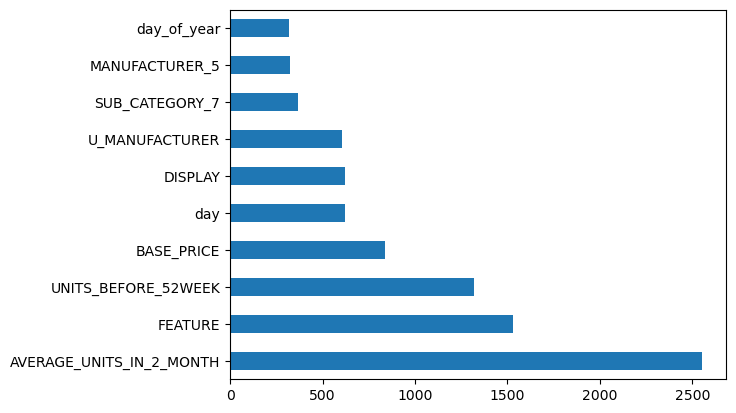

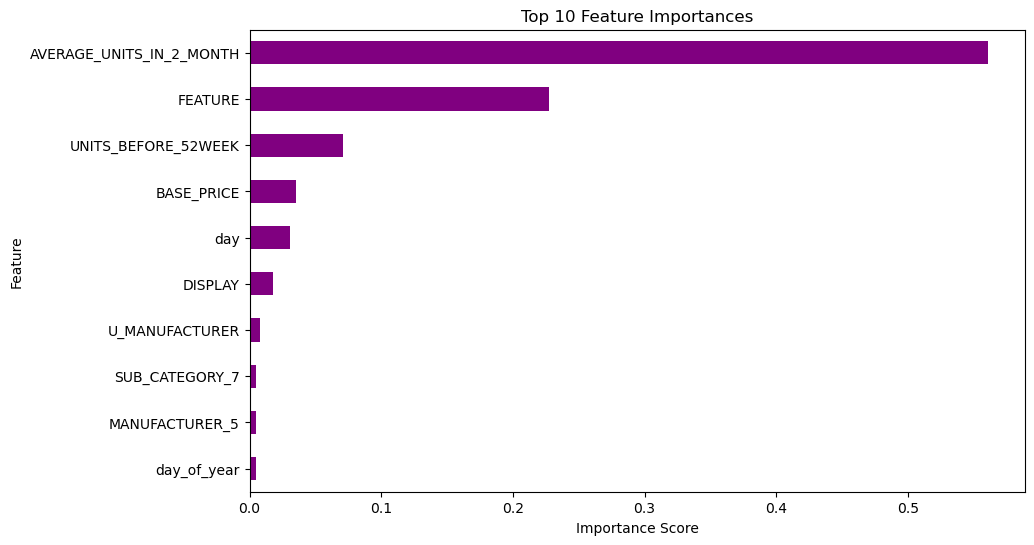

AVERAGE_UNITS_IN_2_MONTH    0.560719
FEATURE                     0.227273
UNITS_BEFORE_52WEEK         0.070904
BASE_PRICE                  0.035488
day                         0.030928
DISPLAY                     0.017632
U_MANUFACTURER              0.007963
SUB_CATEGORY_7              0.005190
MANUFACTURER_5              0.004741
day_of_year                 0.004629
dtype: float64

In [54]:
get_feature_importance(evaluation_sets[0], model_rf)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 13087, number of used features: 34
[LightGBM] [Info] Start training from score 26.033468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

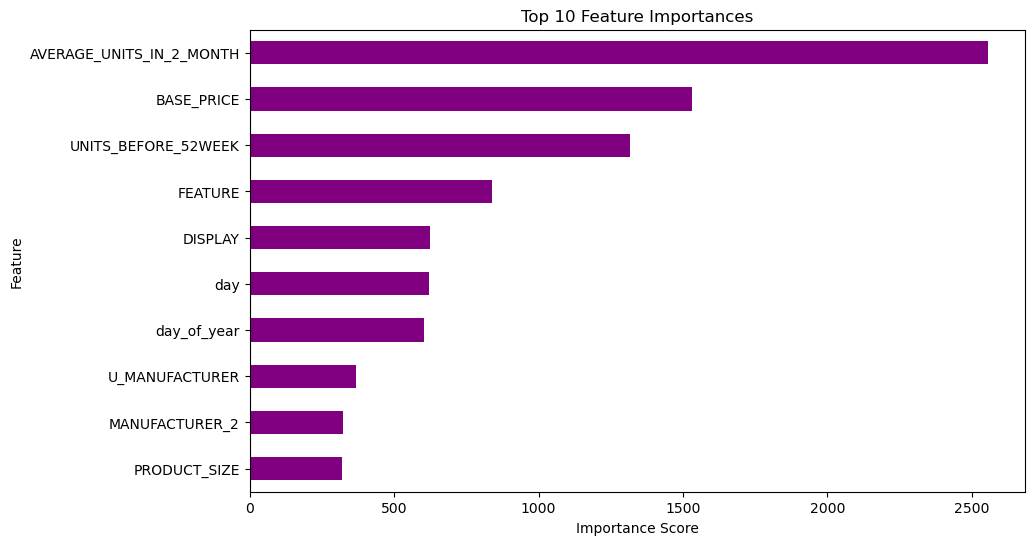

AVERAGE_UNITS_IN_2_MONTH    2555
BASE_PRICE                  1531
UNITS_BEFORE_52WEEK         1318
FEATURE                      840
DISPLAY                      623
day                          620
day_of_year                  603
U_MANUFACTURER               367
MANUFACTURER_2               323
PRODUCT_SIZE                 320
dtype: int32

In [57]:
get_feature_importance(evaluation_sets[0], model_LGBM)